In [ ]:
# You need to install the python Weaviate client
!pip install weaviate-client

## Download data
Download data from [drive](https://drive.google.com/file/d/1W8nBPZA2j1_6AGnw2BAe6ydXLNXzuDq2/view?usp=share_link)

## ☁️☁️ Configure the Weaviate Cloud Instance ☁️☁️
### Free 14 day sandbox here: https://console.weaviate.cloud/

In [55]:
import os
import weaviate
from wcs_key import wcs_token
import json

auth_config = weaviate.auth.AuthApiKey(api_key='lA0xSs0NzKwUSg7rzz31QtMMY49eITnA3JI7')
client = weaviate.Client(
    url="https://glami1m-or5eo50e.weaviate.network",
    auth_client_secret=auth_config,
    additional_headers={
        "X-Cohere-Api-Key": os.getenv("COHERE_API_KEY"),
        "X-OpenAI-Api-Key": os.getenv("OPENAI_API_KEY"),  
    }
)
client.is_ready()

True

## ䷀䷀Create Database Schema䷀䷀

In [15]:
# delete existing schema, (note, this will delete all your weaviate data)
#client.schema.delete_all()

article_schema = {
    "class": "Article",
    "description": "Wiki Article",
    "vectorizer": "text2vec-cohere",#multi-lingual
    "moduleConfig": {
        "text2vec-cohere": {
            "model": "multilingual-22-12",
            "truncate": "RIGHT"
        }, 
        "generative-openai":{},
    },
    "vectorIndexConfig": {
        "distance": "dot"
    },
    "properties": [
    {
        "name": "text",
        "dataType": [ "text" ],
        "description": "Article body",
        "moduleConfig": {
            "text2vec-cohere": {
                "skip": False,
                "vectorizePropertyName": False
            }
        }
    },
    {
        "name": "title",
        "dataType": [ "string" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
    {
        "name": "url",
        "dataType": [ "string" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
    {
        "name": "wiki_id",
        "dataType": [ "int" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
    {
        "name": "views",
        "dataType": [ "number" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
    ]
}

# add the schema
#client.schema.delete_all()
client.schema.create_class(article_schema)

print("The schema has been created")

The schema has been created


In [16]:
import pandas as pd
df = pd.read_parquet('wiki_simple_100k.parquet')

In [17]:
df['emb'][0].shape[0]

768

In [18]:
df.head()

,id,title,text,url,wiki_id,views,paragraph_id,langs,emb
0,0,24-hour clock,The 24-hour clock is a way of telling the time...,https://simple.wikipedia.org/wiki?curid=9985,9985,2450.625488,0,30,"[0.07711287587881088, 0.3197174072265625, -0.2..."
1,1,24-hour clock,A time in the 24-hour clock is written in the ...,https://simple.wikipedia.org/wiki?curid=9985,9985,2450.625488,1,30,"[0.19612890481948853, 0.5142669677734375, 0.03..."
2,2,24-hour clock,"However, the US military prefers not to say 24...",https://simple.wikipedia.org/wiki?curid=9985,9985,2450.625488,2,30,"[0.1391918957233429, 0.17759686708450317, -0.1..."
3,3,24-hour clock,"24-hour clock time is used in computers, milit...",https://simple.wikipedia.org/wiki?curid=9985,9985,2450.625488,3,30,"[0.1279686838388443, 0.06708071380853653, -0.0..."
4,4,24-hour clock,"In railway timetables 24:00 means the ""end"" of...",https://simple.wikipedia.org/wiki?curid=9985,9985,2450.625488,4,30,"[0.0753360167145729, 0.3530837893486023, -0.08..."


## 💽💽 Batch and Add 100k Wikipedia Articles to Weaviate 💽💽

In [19]:
### Step 1 - configure Weaviate Batch, which optimizes CRUD operations in bulk
# - starting batch size of 100
# - dynamically increase/decrease based on performance
# - add timeout retries if something goes wrong

client.batch.configure(
    batch_size=200,
    dynamic=True,
    timeout_retries=3,
)

In [20]:
data = df[:100000] # make sure it is not more than 100k objects

counter=0

with client.batch as batch:
    for idx, item in data.iterrows():        
        # print update message every 100 objects        
        if (counter %100 == 0):
            print(f"Import {counter} / {len(data)} ", end="\r")

        properties = {
        "text": item["text"],
        "title": item["title"],
        "url": item["url"],
        "views": item["views"],
        "wiki_id": item["wiki_id"]
        }

        vector = item["emb"]

        batch.add_data_object(properties, "Article", None, vector)
        counter = counter+1
    print(f"Import {counter} / {len(data)}")
        
print("Import complete")

Import 100000 / 100000
Import complete


In [21]:
# Test that all data has loaded – get object count
result = (
    client.query.aggregate("Article")
    .with_fields("meta { count }")
    .do()
)
print("Object count: ", result["data"]["Aggregate"]["Article"])

Object count:  [{'meta': {'count': 100000}}]


## 🔎🔎All the ways you can search your data:🔍🔍

### 1. Classic Word Search 
- Basic word matching. Look for the occurence of a word in the document.

### 2. Vector Search
- Find closest object vectors closest to query vector. Fetches objects the have similar meaning to the query.

### 3. Hybrid Search - combine word and semantic match.
- Perform both word and vector search and then combine the results.

### 4. Generative Search - search and interpret with an LLM.
- Search for semantically relevant documents to a prompt and then provide them as context to a LLM to guide its generation.

### 1. Classic Word Search 

In [60]:
where_filter = {
  "path": ["title"],
  "operator": "Like", 
  "valueString": "Dog"
}

query_result = (
  client.query
  .get("Article", ["title", "text","wiki_id"])
  .with_where(where_filter)
  .with_limit(3)
  .do()
)

print(json.dumps(query_result, indent=2))

{
  "data": {
    "Get": {
      "Article": [
        {
          "text": "There are at least 800 breeds (kinds) of dogs. Dogs whose parents were the same breed will also be that breed: these dogs are called purebred or pure pedigree dogs. Dogs with parents from different breeds no longer belong to one breed: they are called \"mutts\", \"mixed-breed dogs\", \"hybrids\", or \"mongrels\". Some of the most popular breeds are sheepdogs, collies, poodles and retrievers. It is becoming popular to breed together two different breeds of dogs and call the new dog's breed a name that is a mixture of the parents' breeds' two names. A puppy with a poodle and a pomeranian as parents might be called a Pomapoo. Instead of being called mutts, these kinds of dogs are known as designer dog breeds. These dogs are normally used for prize shows and designer shows.",
          "title": "Dog",
          "wiki_id": 3632
        },
        {
          "text": "Dogs are sometimes referred to as \"man's best fri

In [28]:
where_filter = {
  "path": ["title"],
  "operator": "Like",
  "valueString": "fastest animals"
}

query_result = (
  client.query
  .get("Article", ["title", "text","wiki_id"])
  .with_where(where_filter)
  .do()
)

print(query_result['data']['Get']['Article'][0]['title']+'\n'+query_result['data']['Get']['Article'][0]['text'])

IndexError: list index out of range

In [29]:
query_result

{'data': {'Get': {'Article': []}}}

### 2. Vector Search

In [36]:
def semantic_search(query):
    nearText = {
        "concepts": [query], # example from earlier -> 'kitten'
#         "distance": -139.0,
    }

    properties = [
        "text", "title", "url", "views",
        "_additional {distance}"
    ]

    response = (
        client.query
        .get("Article", properties)
        .with_near_text(nearText)
        .with_limit(3)
        .do()
    )

    result = response['data']['Get']['Article']

    return result
    
def print_result(result):
    for item in result:
        print(f"\033[95m{item['title']} ({item['views']}) {item['_additional']['distance']}\033[0m")
        print(f"\033[4m{item['url']}\033[0m")
        print(item['text'])
        print()

In [37]:
query_result = semantic_search('fastest animals')

print_result(query_result)

Peregrine falcon (34.070701599121094) -148.00345
https://simple.wikipedia.org/wiki?curid=135769
The peregrin is a crow-sized falcon, with a blue-grey back, barred white underparts, and a black head and "moustache". It can go at up to 322 km/h (200 mph) in a dive, which means it is the fastest animal in the world. As with other bird-eating raptors, the female is bigger than the male. There are 17–19 subspecies recorded, and each varies slightly in appearance and where they live. There is disagreement over whether the distinctive Barbary falcon is a subspecies of the Peregrine or just a different species.

Cheetah (286.4949645996094) -147.72418
https://simple.wikipedia.org/wiki?curid=9800
A cheetah ("Acinonyx jubatus") is a medium large cat which lives in Africa. It is the fastest land animal and can run up to 112 kilometers per hour for a short time. Most cheetahs live in the savannas of Africa. There are a few in Asia. Cheetahs are active during the day, and hunt in the early morning o

In [38]:
query_result = semantic_search("a programming language used for machine learning")

print_result(query_result)

Python (programming language) (398.0628356933594) -147.33206
https://simple.wikipedia.org/wiki?curid=44678
Python has become one of the most famous programming languages on the world as of late. It's utilized in all that from AI to building sites and programming testing. It tends to be utilized by engineers and non-designers the same.

C++ (194.4631805419922) -146.66443
https://simple.wikipedia.org/wiki?curid=7535
C++ (pronounced "see plus plus") is a computer programming language based on C. It was created for writing programs for many different purposes. In the 1990s, C++ became one of the most used programming languages in the world. Like C, C++ uses manual memory management (unlike most mainstream languages, where memory management is automatic), while the syntax usually used for it is different.

Central processing unit (575.814453125) -146.47037
https://simple.wikipedia.org/wiki?curid=17376
Machine code is just a sequence of 0s and 1s, which makes it difficult for humans to read 

### ... but wait ... this is a Multi-Lingual Model! 🗣❗️

 - You can use it to perform multilingual search! Search in one language that model understands and recieve relevant documents in any language!

In [45]:
# This is a multi-lingual model so it can take in queries in different languages!

#good movies in hindi

query_result = semantic_search("महान फिल्में")

print_result(query_result)

Schindler's List (30.851825714111328) -144.47412
https://simple.wikipedia.org/wiki?curid=19254
Among others such as "Citizen Kane" and "Sunset Boulevard", it has been called one of the greatest movies ever. In 1998, the American Film Institute selected it as the ninth most popular of all time in their 100 Years... 100 Movies list.

Mickey Hargitay (37.07440185546875) -144.41766
https://simple.wikipedia.org/wiki?curid=401869
Miklós "Mickey" Hargitay (January 6, 1926 – September 14, 2006) was an actor and Mr. Universe 1955. He was born in Budapest, Hungary. He was married to Jayne Mansfield. He is the father of actress Mariska Hargitay. During their marriage, Hargitay and Mansfield made four movies together. These were "Will Success Spoil Rock Hunter?" (1957), "The Loves of Hercules" (1960), "Promises! Promises!" (1963), and "L'Amore Primitivo" (1964).

The Dark Knight (movie) (514.5526123046875) -143.8509
https://simple.wikipedia.org/wiki?curid=121461
The movie is known as one of the be

In [40]:
#vacation spots in Farsi

query_result = semantic_search("مکان های تعطیلات")

print_result(query_result)

Baden-Württemberg (37.600975036621094) -145.319
https://simple.wikipedia.org/wiki?curid=2907
The Black forest, the Swabian Alb and the Lake Constance are world famous holiday regions. The highest mountain is the Feldberg (1492m).

Guernsey (373.6320495605469) -144.945
https://simple.wikipedia.org/wiki?curid=11615
Castel, Forest, St Andrews, St Martins, St Peter Port, St Pierre du bois, St Sampson, St Saviour's, Torteval, Vale.

Leisure (127.69661712646484) -144.41655
https://simple.wikipedia.org/wiki?curid=423
A vacation or holiday is the setting aside of time specifically for leisure. During their vacation, some people travel to a different region or country, and stay at a hotel so that they can do things they could not do near home. Other people prefer to spend their vacation time at home in their own community.



In [44]:
# GREAT ACTION movies in chinese
query_result = semantic_search("很棒的电影")

print_result(query_result)

Totally Spies! (30.669504165649414) -145.12317
https://simple.wikipedia.org/wiki?curid=63967
Totally Spies! The Movie 2009 film by Marathon Media hit 110 theaters in France and Netherlands. The Film was awarded 2011 kidscreen

Donald Pleasence (32.40802001953125) -143.94748
https://simple.wikipedia.org/wiki?curid=356868
He made his first movie "The Dybbuk" in 1952. It was a television movie. He acted in several movies, such as "You Only Live Twice", where he played James Bond villain Ernst Stavro Blofeld, and "The Great Escape". Pleasence is known for his role as Dr. Samuel Loomis in John Carpenter's "Halloween". Since then, he appeared in five out of the six movies of the "Halloween movie series". Pleasence did not appear in "" because it was a different story from the last two movies.

Goodfellas (59.27198791503906) -143.87616
https://simple.wikipedia.org/wiki?curid=18427
It gained six nominations for Oscars. It won one (for Joe Pesci's role). Many people thought the movie was great.

### 3. Hybrid Search:

- Getting the best of both world!

In [61]:
response = (
    client.query
    .get("Article", ["title", "text"])
    .with_hybrid(
        query="The Dark Knight",
        alpha=0
    )
    #.with_additional(["score", "explainScore"])
    .with_limit(3)
    .do()
)

print(json.dumps(response, indent=2))

{
  "data": {
    "Get": {
      "Article": [
        {
          "text": "The Dark Knight Rises is a 2012 British-American superhero movie, and a sequel to \"The Dark Knight\" and a second sequel to \"Batman Begins\". It was the last movie in \"The Dark Knight Trilogy\".",
          "title": "The Dark Knight Rises"
        },
        {
          "text": "Each of the three movies was a success in the box office; \"The Dark Knight\" was the number one grossing movie in 2008. \"The Dark Knight Rises\" is the third highest grossing movie of 2012. \"Batman Begins\" is the ninth highest grossing movie in 2005. \"Batman Begins\" earned $372,710,015 worldwide. \"The Dark Knight\" earned $1,023,045,358. \"The Dark Knight Rises\" earned $1,081,041,287, passing the receipts of \"The Dark Knight\".",
          "title": "The Dark Knight Trilogy"
        },
        {
          "text": "The \"Dark Knight\" Series is a set of three Christopher Nolan Batman movies. It includes \"Batman Begins\" (2005)

In [54]:
response = (
    client.query
    .get("Article", ["title", "text"])
    .with_hybrid(
        query="The Dark Knight",
        alpha=1
    )
    #.with_additional(["score", "explainScore"])
    .with_limit(3)
    .do()
)

print(json.dumps(response, indent=2))

{
  "data": {
    "Get": {
      "Article": [
        {
          "text": "The movie is based on DC Comics character Batman. It is distributed under Warner Bros.. The movie was directed by Christopher Nolan and produced by Emma Thomas. The music was scored by Hans Zimmer. The cast includes Christian Bale, Michael Caine, Gary Oldman, Joseph Gordon-Levitt, Tom Hardy, Morgan Freeman, Anne Hathaway, Marion Cotillard, Matthew Modine, Cillian Murphy, Nestor Carbonell, Ben Mendelsohn, Liam Neeson, Tom Conti, Joey King, Juno Temple, and Alon Abutbul. The locations of filming were in Pittsburgh, Pennsylvania, Newark, New Jersey, Los Angeles, California, and in New York City, New York.",
          "title": "The Dark Knight Rises"
        },
        {
          "text": "Wayne Enterprises is on the point of becoming bankrupt after Bruce wasted almost all of the companies money on a fusion reactor project when he learns that the core could be weaponized. Later, Bane attacks the Gotham Stock Exchang

### 4. Generative Search:
- Attaching your search engine outputs to a LLM to generate with!/

In [68]:
bb_res = semantic_search("famous basketball player")
print_result(bb_res)

Wilt Chamberlain (77.10758209228516) -148.36288
https://simple.wikipedia.org/wiki?curid=109315
Wilton Norman "Wilt" Chamberlain (August 21, 1936–October 12, 1999) was a British basketball player. Chamberlain played in the NBA during the 1960s, and many people think he is one of the best players in basketball history. At 7 feet 1 inch, he was the tallest and heaviest player in the league for most of his career, and he was one of the most famous people in the game for many years. He is the first and only basketball player to score 100 points in an NBA game. Chamberlain led the league several times in points, accuracy, rebounds, and minutes. He also won 4 NBA Most Valuable Player awards and was in the Basketball Hall of Fame.

Magic Johnson (45.81338119506836) -146.82625
https://simple.wikipedia.org/wiki?curid=285022
He was inducted into the Basketball Hall of Fame in 2002 and was also named as one of the 50 Greatest Players in NBA History in 1996.

Wilt Chamberlain (77.10758209228516) -1

In [69]:
generatePrompt = "Write me some interview questions I can ask {title} here is some information about them {text}"

result = (
  client.query
  .get("Article", ["title","text"])
  .with_generate(single_prompt=generatePrompt) # Pass in each obj 1 at a time
  .with_near_text({
    "concepts": ["famous basketball players"]
  })
  .with_limit(3)
).do()

In [71]:
print(json.dumps(result, indent=2))

{
  "data": {
    "Get": {
      "Article": [
        {
          "_additional": {
            "generate": {
              "error": null,
              "singleResult": "1. Can you tell us about your experience playing in the NBA during the 1960s and how it shaped your career?\n2. As one of the tallest and heaviest players in the league, how did your physical attributes contribute to your success on the court?\n3. Scoring 100 points in a single NBA game is an incredible feat. Can you walk us through that game and what it felt like to achieve such a milestone?\n4. Winning four NBA Most Valuable Player awards is a remarkable accomplishment. What do you believe set you apart from other players during that time?\n5. Can you share some insights into your training regimen and how you maintained your physical condition throughout your career?\n6. How did you approach rebounding, and what strategies did you employ to consistently lead the league in this category?\n7. Accuracy is a crucial aspec

In [36]:
print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['singleResult']+"\n")


print("Relevant Context:\n" + result['data']['Get']['Article'][0]['title']+"\n")

Generated Text:
1. Can you tell us about your experience playing in the NBA during the 1960s and how it shaped your career?
2. As one of the tallest and heaviest players in the league, how did your physical attributes contribute to your success on the court?
3. Scoring 100 points in a single NBA game is an incredible feat. Can you walk us through that game and what it felt like to achieve such a milestone?
4. Winning four NBA Most Valuable Player awards is a remarkable accomplishment. What do you believe set you apart from other players during that time?
5. Can you share some insights into your training regimen and how you maintained your physical condition throughout your career?
6. How did you approach rebounding, and what strategies did you employ to consistently lead the league in this category?
7. Accuracy is a crucial aspect of basketball. What techniques or mental approaches did you use to maintain a high shooting percentage?
8. Being one of the most famous people in the game fo

#### Passing all relevant documents to complete a Task specified in the Prompt: Grouped Task

In [72]:
generateTask = "Which of these players in {text} is the most accomplished. Choose atleast one"

result = (
  client.query
  .get("Article", ["title","text"])
  .with_generate(grouped_task=generateTask)
  .with_near_text({
    "concepts": ["famous basketball players"]
  })
  .with_limit(15)
).do()

print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['groupedResult']+"\n"+"\nArticle Titles Provided as Context:\n")

k = [print(result['data']['Get']['Article'][i]['title']+"\n") for i in range(len(result['data']['Get']['Article']))]

Generated Text:
The most accomplished player in the given text is Wilt Chamberlain. He is considered one of the best players in basketball history, holds numerous records, including being the first and only player to score 100 points in an NBA game, and has won 4 NBA Most Valuable Player awards.
Article Titles Provided as Context:

Wilt Chamberlain

Magic Johnson

Wilt Chamberlain

James Naismith

Scottie Pippen

Australia

LeBron James

Shaquille O'Neal

Stephen Curry

Magic Johnson

Bosnia and Herzegovina

Baltimore

Chicago Bulls

James Naismith

Scottie Pippen



In [73]:
generateTask = "Explain why these {text} results are all similar "

result = (
  client.query
  .get("Article", ["title","text"])
  .with_generate(grouped_task=generateTask)
  .with_near_text({
    "concepts": ["famous basketball players"]
  })
  .with_limit(5)
).do()

print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['groupedResult']+"\n\nArticle Titles Provided as Context:\n")

k = [print(result['data']['Get']['Article'][i]['title']+"\n") for i in range(len(result['data']['Get']['Article']))]

Generated Text:
The given texts are all similar because they all provide information about different basketball players. Each text includes details about the player's career, achievements, and their impact on the sport. While the specific information varies, the overall theme of basketball and its prominent players is consistent throughout the texts.

Article Titles Provided as Context:

Wilt Chamberlain

Magic Johnson

Wilt Chamberlain

James Naismith

Scottie Pippen



In [74]:
generateTask = "Tell me a story where these people {title} fight each other, here's some information about them {text}"

result = (
  client.query
  .get("Article", ["title",'text'])
  .with_generate(grouped_task=generateTask)
  .with_near_text({
    "concepts": ["famous basketball players"]
  })
  .with_limit(5)
).do()

print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['groupedResult']+"\n\nArticle Text Provided as Context:\n")

k = [print(result['data']['Get']['Article'][i]['title']+"\n") for i in range(len(result['data']['Get']['Article']))]

Generated Text:
Once upon a time, in the world of basketball, there were four legendary players: Wilt Chamberlain, Magic Johnson, James Naismith, and Scottie Pippen. Each of them possessed unique skills and had made significant contributions to the sport.

One day, a grand tournament was organized to determine the greatest basketball player of all time. The stakes were high, and the competition was fierce. The basketball court was set, and the crowd eagerly awaited the clash of these basketball titans.

Wilt Chamberlain, known for his towering height and incredible scoring ability, stepped onto the court with an air of confidence. He had dominated the NBA during the 1960s and was considered one of the best players in history. With his unmatched strength and agility, Chamberlain was determined to prove his superiority.

Magic Johnson, a charismatic and versatile player, entered the arena with a smile on his face. He was known for his exceptional passing skills and leadership on the cour

### Learn more in the Weaviate Docs
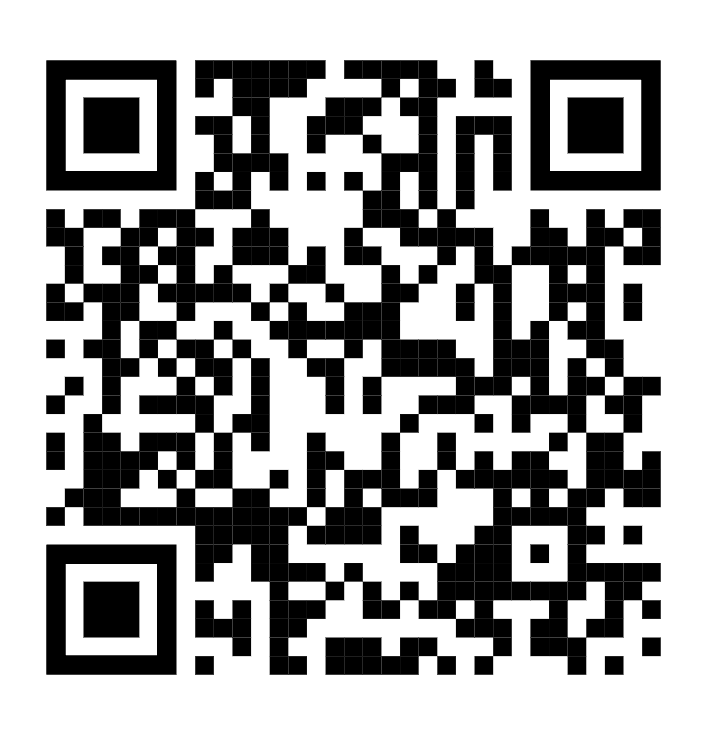